#Librerias

In [1]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import estimate_bandwidth
from sklearn.utils import resample
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score

In [2]:
drive.mount('/content/drive')
df = pd.concat(
    pd.read_excel("/content/drive/MyDrive/Colab Notebooks/online_retail_II.xlsx",
                 sheet_name=['Year 2009-2010', 'Year 2010-2011']),
    ignore_index=True
)

Mounted at /content/drive


#Limpieza

In [3]:
def eliminar_duplicados_personalizados(df, columnas_clave=None, considerar_fecha=True, verbose=True):
    """
    Identifica y elimina duplicados
    """
    columnas_clave = ['Invoice', 'StockCode', 'Quantity','Price','InvoiceDate']
    # Contar duplicados
    duplicados = df.duplicated(subset=columnas_clave, keep='first').sum()

    # Eliminar duplicados
    df_limpio = df.drop_duplicates(subset=columnas_clave, keep='first')

    # Mostrar información si verbose=True
    if verbose:
        print("\n=== Análisis de duplicados ===")
        print(f"Registros originales: {len(df)}")
        print(f"Registros duplicados: {duplicados}")
        print(f"Registros único: {len(df_limpio)}")
        print(f"Porcentaje de duplicados: {duplicados/len(df)*100:.2f}%")

    return df_limpio, duplicados

In [4]:
df_limpio, num_duplicados = eliminar_duplicados_personalizados(df)


=== Análisis de duplicados ===
Registros originales: 1067371
Registros duplicados: 34337
Registros único: 1033034
Porcentaje de duplicados: 3.22%


In [5]:
def filtrar_irrelevantes(df):
    """
    Elimina transacciones sin ID de cliente
    Elimina pedidos cancelados (facturas que comienzan con 'C')
    """
    df_filtrado = df.copy()
    # 1. Eliminar registros sin Customer ID
   # df_filtrado = df_filtrado.dropna(subset=['Customer ID'])

    # 2. Eliminar cancelaciones (facturas que empiezan con 'C')
    cancelaciones = df_filtrado[df_filtrado['Invoice'].astype(str).str.startswith('C')].index
    df_filtrado = df_filtrado.drop(cancelaciones)

    # 3. Eliminar precios negativos
    precios_negativos = df_filtrado[df_filtrado['Price'] < 0]
    df_filtrado = df_filtrado.drop(precios_negativos.index)

    precios_negativos = df_filtrado[df_filtrado['Quantity'] < 0]
    df_filtrado = df_filtrado.drop(precios_negativos.index)

    df_filtrado['Description'] = df_filtrado['Description'].fillna('Unspecified')
    df_filtrado['Customer ID'] = df_filtrado['Customer ID'].fillna(0)

    #print(f"- Sin Customer ID: {len(df) - len(df_filtrado) - df_filtrado['Invoice'].astype(str).str.startswith('C').sum()}")
    print(f"- Cancelaciones: {df_filtrado['Invoice'].astype(str).str.startswith('C').sum()}")
    print(f"- Precios negativos: {len(precios_negativos)}")
    print(f"- Cantidades negativas: {len(precios_negativos)}")
    print(f"Total final: {len(df_filtrado)} registros")
    return df_filtrado

In [6]:
df_limpio = filtrar_irrelevantes(df_limpio)

- Cancelaciones: 0
- Precios negativos: 3393
- Cantidades negativas: 3393
Total final: 1010532 registros


In [7]:
df_limpio['Invoice'] = df_limpio['Invoice'].astype('string')
df_limpio['StockCode'] = df_limpio['StockCode'].astype('string')
df_limpio['Country'] = df_limpio['Country'].astype('string')
df_limpio['Description'] = df_limpio['Description'].astype('string')
df_limpio['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1010532 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1010532 non-null  string        
 1   StockCode    1010532 non-null  string        
 2   Description  1010532 non-null  string        
 3   Quantity     1010532 non-null  int64         
 4   InvoiceDate  1010532 non-null  datetime64[ns]
 5   Price        1010532 non-null  float64       
 6   Customer ID  1010532 non-null  float64       
 7   Country      1010532 non-null  string        
dtypes: datetime64[ns](1), float64(2), int64(1), string(4)
memory usage: 69.4 MB


In [8]:
df_limpio['TotalValue'] = df_limpio['Quantity'] * df_limpio['Price']
df_limpio['day_of_week'] = df_limpio['InvoiceDate'].dt.dayofweek
df_limpio['hour'] = df_limpio['InvoiceDate'].dt.hour
df_limpio['day'] = df_limpio['InvoiceDate'].dt.day

#Parte 2


In [9]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1010532 entries, 0 to 1067370
Data columns (total 12 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1010532 non-null  string        
 1   StockCode    1010532 non-null  string        
 2   Description  1010532 non-null  string        
 3   Quantity     1010532 non-null  int64         
 4   InvoiceDate  1010532 non-null  datetime64[ns]
 5   Price        1010532 non-null  float64       
 6   Customer ID  1010532 non-null  float64       
 7   Country      1010532 non-null  string        
 8   TotalValue   1010532 non-null  float64       
 9   day_of_week  1010532 non-null  int32         
 10  hour         1010532 non-null  int32         
 11  day          1010532 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(3), int64(1), string(4)
memory usage: 88.7 MB


In [10]:
# Seleccionar características relevantes para clustering
features = ['TotalValue', 'Quantity', 'Price', 'day_of_week', 'hour']
X = df_limpio[features]
X
# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##K-Means

K-Means es un algoritmo de clustering no supervisado que agrupa datos en K clusters basados en similitud. Comienza con K centroides aleatorios, asigna cada punto al más cercano (distancia euclidiana) y recalcula los centroides iterativamente hasta converger.

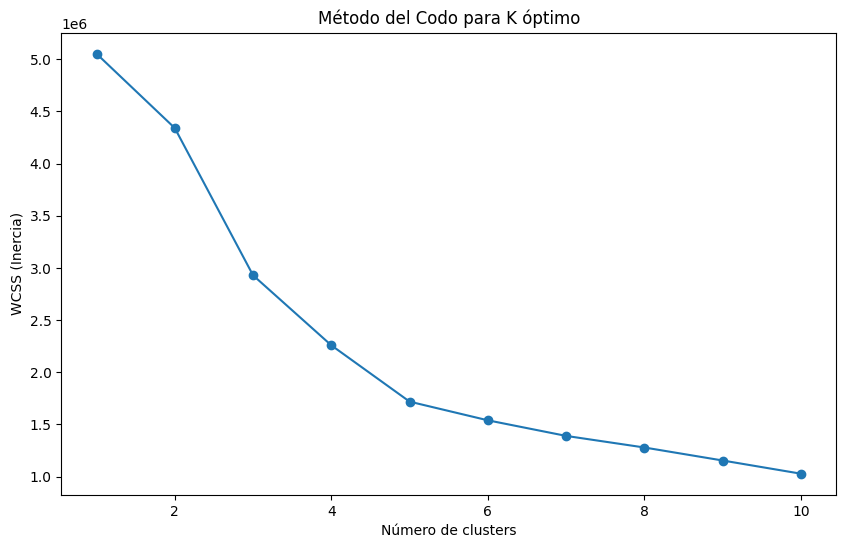

In [11]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Método del Codo para K óptimo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS (Inercia)')
plt.show()

In [12]:
k = 3  # Basado en el método del codo
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)
df_limpio['Cluster_Kmeans'] = kmeans.labels_

###Resultados

📌 Cantidad de registros por cluster (K-means):
Cluster_Kmeans
0    503455
1    507075
2         2
Name: count, dtype: int64

--------------------------------------------------

📊 Promedios por cluster para variables clave:
                TotalValue  Quantity  Price  day_of_week   hour
Cluster_Kmeans                                                 
0                    21.83     12.93   3.70         3.45  11.42
1                    18.22      9.45   4.43         1.48  14.61
2                122826.60  77605.00   1.56         2.50   9.50

--------------------------------------------------



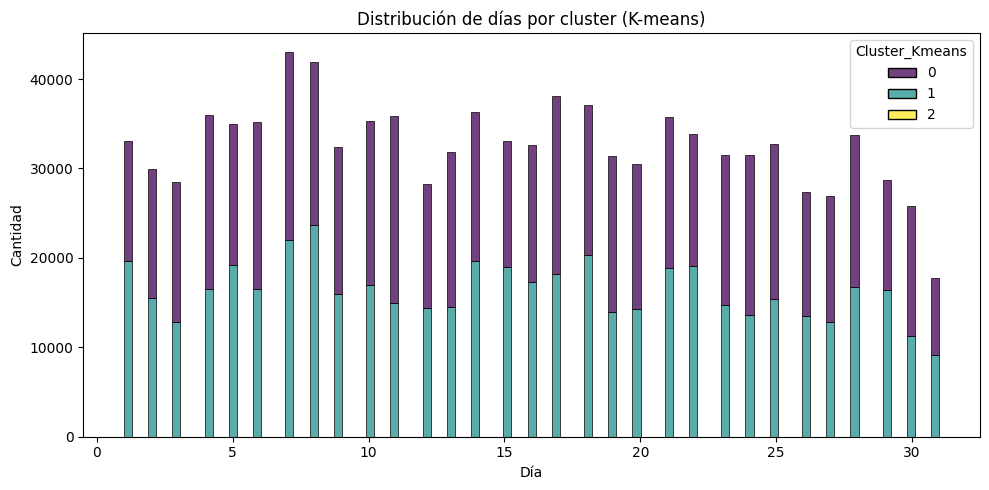

In [13]:
# 1. Conteo de registros por cluster
print("📌 Cantidad de registros por cluster (K-means):")
print(df_limpio['Cluster_Kmeans'].value_counts().sort_index())
print("\n" + "-"*50 + "\n")

# 2. Promedios por cluster
print("📊 Promedios por cluster para variables clave:")
resumen_cluster = df_limpio.groupby('Cluster_Kmeans')[['TotalValue', 'Quantity', 'Price', 'day_of_week', 'hour']].mean().round(2)
print(resumen_cluster)
print("\n" + "-"*50 + "\n")

# 3. Visualización
plt.figure(figsize=(10, 5))
sns.histplot(data=df_limpio, x='day', hue='Cluster_Kmeans', multiple='stack', palette='viridis')
plt.title('Distribución de días por cluster (K-means)')
plt.xlabel('Día')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()


## Meanshift

MeanShift es un algoritmo de clustering no supervisado basado en densidad, que no requiere especificar el número de clusters (a diferencia de K-Means). Utiliza un ancho de banda para definir la región de búsqueda y desplaza puntos hacia áreas de mayor densidad mediante gradiente ascendente, convergiendo en los modos de la distribución.

In [14]:
from sklearn.cluster import estimate_bandwidth
from sklearn.utils import resample
import numpy as np

# Muestreo aleatorio
X_sample = resample(X_scaled, n_samples=10_000, random_state=42)

# 2. Estimación rápida de bandwidth
bandwidth = estimate_bandwidth(X_sample, quantile=0.2, n_jobs=-1)

print(f"Bandwidth estimado: {bandwidth:.2f}")

Bandwidth estimado: 1.10


In [15]:
meanshift = MeanShift(
    bandwidth=1.1,
    bin_seeding=True,
    min_bin_freq=10,
    n_jobs=-1)

meanshift.fit(X_scaled)

MeanShift(bandwidth=1.1, bin_seeding=True, min_bin_freq=10, n_jobs=-1)

###Resultados

In [16]:
df_limpio['Cluster_MeanShift'] = meanshift.labels_

# Número de clusters encontrados
n_clusters_mean = len(set(meanshift.labels_))
print(f"Mean Shift encontró {n_clusters_mean} clusters")

Mean Shift encontró 10 clusters


📌 Cantidad de registros por cluster (Mean Shift):
Cluster_MeanShift
0    540636
1    466632
2       638
3       219
4       356
5       279
6       730
7       204
8       303
9       535
Name: count, dtype: int64

--------------------------------------------------

📊 Promedios por cluster para variables clave (Mean Shift):
                   TotalValue  Quantity    Price  day_of_week   hour
Cluster_MeanShift                                                   
0                       17.98     10.05     3.43         1.00  13.02
1                       17.23      9.65     3.24         4.16  13.02
2                      161.12      1.24   148.20         1.52  15.53
3                      162.26      1.19   146.69         0.63  10.64
4                      153.55      2.42   109.40         3.24  10.63
5                      314.05      1.01   309.89         1.99  13.10
6                      957.53    346.54     4.82         1.58  13.94
7                      937.25    343.54     4.44     

<ipython-input-17-5469e2a73308>:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')


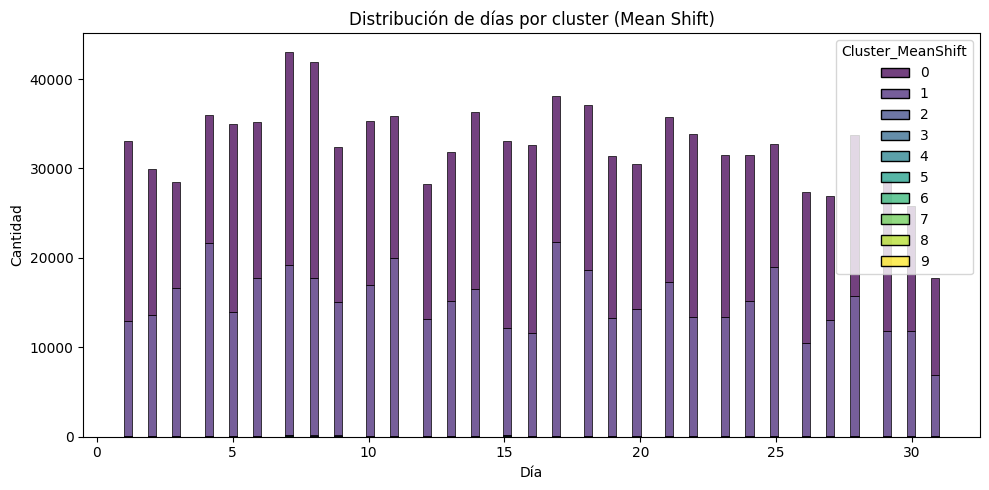

In [17]:
# 1. Conteo de registros por cluster
print("📌 Cantidad de registros por cluster (Mean Shift):")
print(df_limpio['Cluster_MeanShift'].value_counts().sort_index())
print("\n" + "-"*50 + "\n")

# 2. Promedios por cluster
print("📊 Promedios por cluster para variables clave (Mean Shift):")
resumen_meanshift = df_limpio.groupby('Cluster_MeanShift')[['TotalValue', 'Quantity', 'Price', 'day_of_week', 'hour']].mean().round(2)
print(resumen_meanshift)
print("\n" + "-"*50 + "\n")

# 3. Visualización
plt.figure(figsize=(10, 5))
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.histplot(data=df_limpio, x='day', hue='Cluster_MeanShift', multiple='stack', palette='viridis')
plt.title('Distribución de días por cluster (Mean Shift)')
plt.xlabel('Día')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()

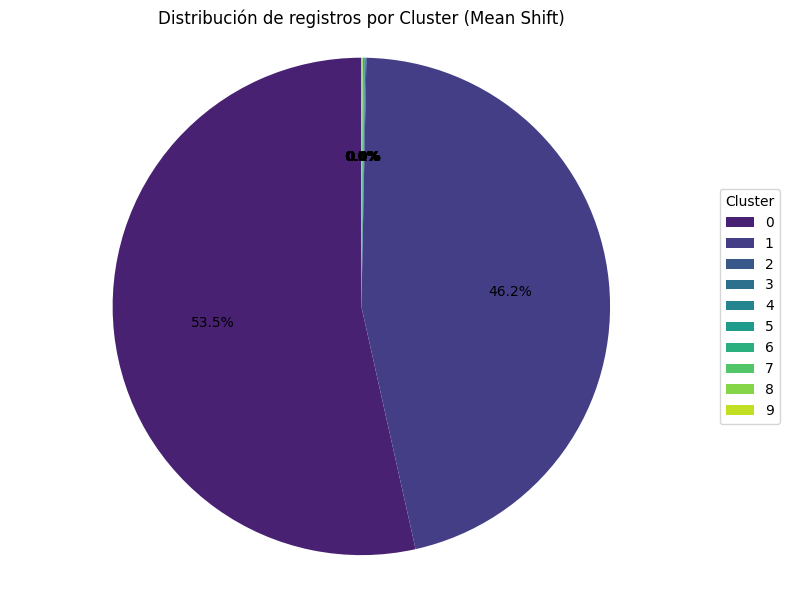

In [18]:

df_limpio['Cluster_MeanShift'] = df_limpio['Cluster_MeanShift'].astype(str)

# Contar elementos por cluster
cluster_counts = df_limpio['Cluster_MeanShift'].value_counts().sort_index()

# Colores para los clusters
colors = sns.color_palette('viridis', n_colors=len(cluster_counts))

# Crear gráfico
plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(
    cluster_counts,
    labels=None,  # No mostrar etiquetas dentro del gráfico
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)

# Agregar leyenda al lado
plt.legend(wedges, cluster_counts.index, title="Cluster", loc="center left", bbox_to_anchor=(1, 0.5))

# Título y ajustes
plt.title('Distribución de registros por Cluster (Mean Shift)')
plt.axis('equal')  # Círculo perfecto
plt.tight_layout()
plt.show()


##Comparación

In [19]:
df_limpio.groupby('Cluster_Kmeans')[['TotalValue', 'Quantity', 'Price', 'day_of_week', 'hour']].mean().round(2)


,TotalValue,Quantity,Price,day_of_week,hour
Cluster_Kmeans,,,,,
0,21.83,12.93,3.70,3.45,11.42
1,18.22,9.45,4.43,1.48,14.61
2,122826.60,77605.00,1.56,2.50,9.50


In [20]:
df_limpio.groupby('Cluster_MeanShift')[['TotalValue', 'Quantity', 'Price', 'day_of_week', 'hour']].mean().round(2)

,TotalValue,Quantity,Price,day_of_week,hour
Cluster_MeanShift,,,,,
0,17.98,10.05,3.43,1.00,13.02
1,17.23,9.65,3.24,4.16,13.02
2,161.12,1.24,148.20,1.52,15.53
3,162.26,1.19,146.69,0.63,10.64
4,153.55,2.42,109.40,3.24,10.63
5,314.05,1.01,309.89,1.99,13.10
6,957.53,346.54,4.82,1.58,13.94
7,937.25,343.54,4.44,4.07,10.67
8,1599.02,1.00,1599.02,1.93,13.50


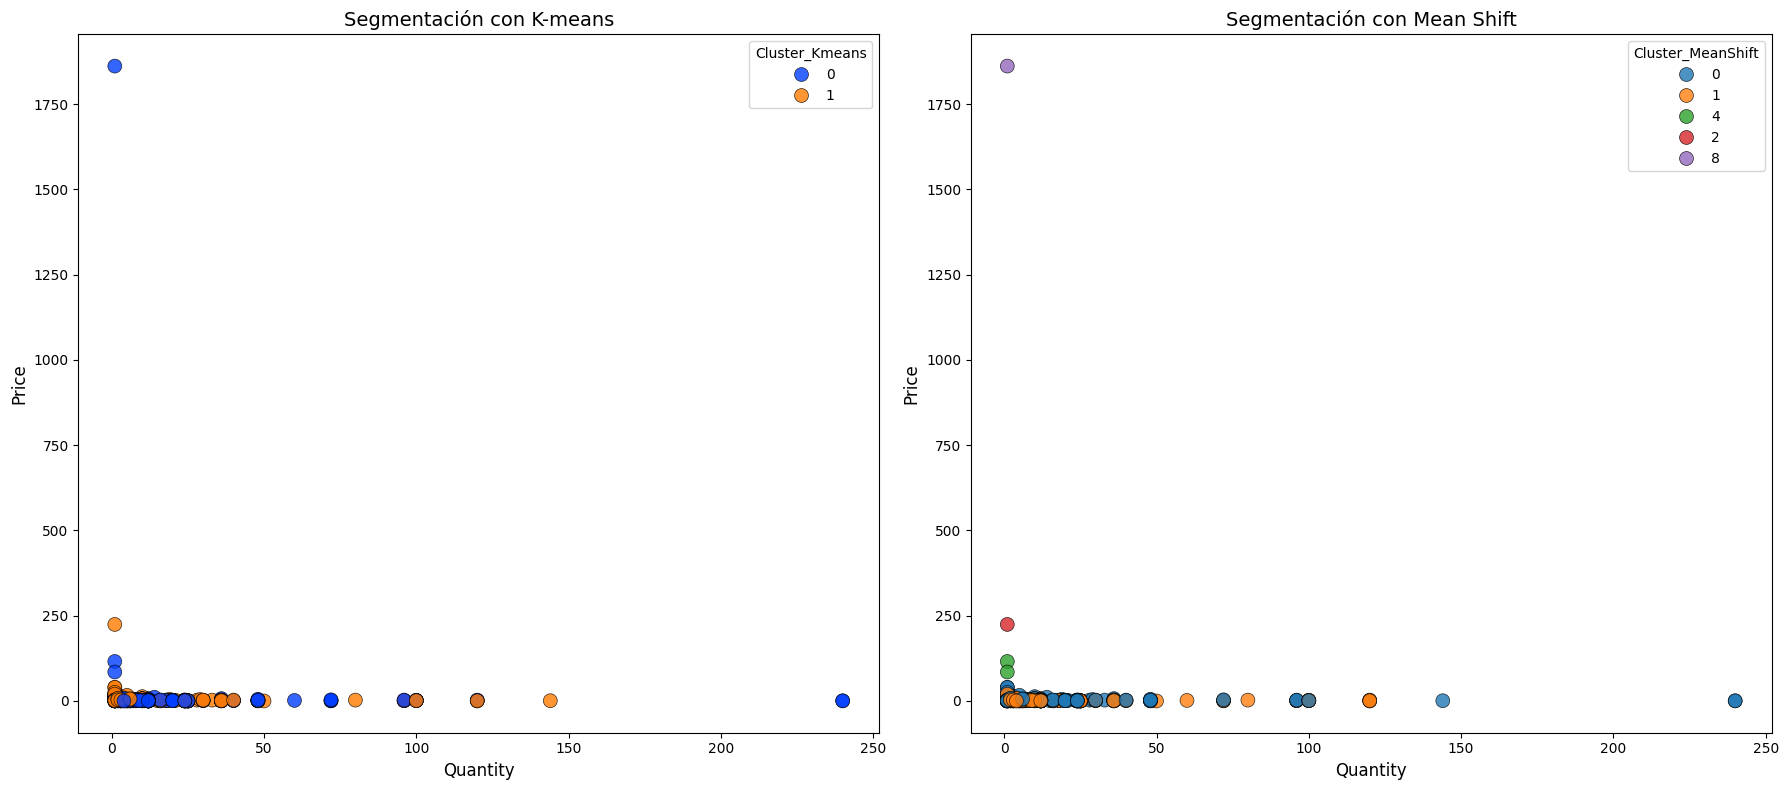

In [26]:
df_sample = df_limpio.sample(n=1000, random_state=42)

# Configurar el gráfico
plt.figure(figsize=(18, 8))

#K-means
plt.subplot(1, 2, 1)
sns.scatterplot(
    x='Quantity',
    y='Price',
    hue='Cluster_Kmeans',
    data=df_sample,
    palette='bright',
    s=100,
    alpha=0.8,
    edgecolor='k',
    linewidth=0.5
)
plt.title('Segmentación con K-means', fontsize=14)
plt.xlabel('Quantity', fontsize=12)
plt.ylabel('Price', fontsize=12)

#Mean Shift
plt.subplot(1, 2, 2)
sns.scatterplot(
    x='Quantity',
    y='Price',
    hue='Cluster_MeanShift',
    data=df_sample,
    palette='tab10',   # Otra paleta alternativa
    s=100,
    alpha=0.8,
    edgecolor='k',
    linewidth=0.5
)
plt.title('Segmentación con Mean Shift', fontsize=14)
plt.xlabel('Quantity', fontsize=12)
plt.ylabel('Price', fontsize=12)

plt.tight_layout()
plt.show()

In [23]:
# ===== Parámetros de muestreo =====
n_muestra = 10000
random_state = 42

# ===== Muestra para K-means =====
X_km, labels_km = resample(
    X_scaled,
    kmeans.labels_,
    n_samples=n_muestra,
    random_state=random_state
)
score_km = silhouette_score(X_km, labels_km)
print(f"Silhouette Score K-means (muestra {n_muestra}): {score_km:.3f}")

# ===== Muestra para Mean Shift =====
X_ms, labels_ms = resample(
    X_scaled,
    meanshift.labels_,
    n_samples=n_muestra,
    random_state=random_state
)
score_ms = silhouette_score(X_ms, labels_ms)
print(f"Silhouette Score Mean Shift (muestra {n_muestra}): {score_ms:.3f}")


Silhouette Score K-means (muestra 10000): 0.322
Silhouette Score Mean Shift (muestra 10000): 0.329


En resumen podemos decir que la principal diferencia entre ambos algoritmos se basa en el número de clusters usados. El Silhouette Score nos dice que Mean Shift (0.329) supera ligeramente a K-means (0.322). Este resultado sugiere, que en K-means, Número de clusters (k) podría no ser el óptimo  y en Mean Shift el ancho de banda (bandwidth) puede estar mal ajustado debido a la muestra usada para el cálculo de este número. Por otro lado, debido al agrupamiento realizado se ve que dos clusters es un buen número para los datos.